In [1]:
import tensorflow as tf

2023-04-10 16:29:20.618676: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 16:29:20.646824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 16:29:21.128863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import datetime
from models import Encoder, Decoder, DisentangleVAE
import constants as c

In [4]:
def npy_header_offset(npy_path):
    with open(str(npy_path), 'rb') as f:
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()
    
def get_split_dataset(path):
    num_feats = 64 * 64 * 3
    # dtype = tf.uint8
    # path = os.path.abspath('./carracing_data/car{}/{}/obs.npy'.format(car_no, split_no))
    # header_offset = npy_header_offset(path)

    dataset = tf.data.FixedLengthRecordDataset([path], num_feats * tf.uint8.size, header_bytes=128)
    dataset = dataset.map(lambda s: tf.reshape(tf.cast(tf.io.decode_raw(s, tf.uint8), dtype=tf.float32) / 255., (64, 64, 3)))
    return dataset

In [5]:
dataset_list = []
for car_no in range(1, 6):
    dataset_list.append(get_split_dataset(os.path.abspath('./carracing_data/car{}/{}/obs.npy'.format(car_no, 0))))
    for split in range(1, 10):
        dataset_list[-1] = dataset_list[-1].concatenate(get_split_dataset(os.path.abspath('./carracing_data/car{}/{}/obs.npy'.format(car_no, split))))
    dataset_list[-1] = dataset_list[-1].shuffle(5000).batch(c.BATCH_SIZE)
dataset = tf.data.Dataset.zip(tuple(dataset_list)).prefetch(tf.data.experimental.AUTOTUNE)

2023-04-10 16:29:21.977481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 16:29:21.995979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 16:29:21.996129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## VAE

In [6]:
encoder = Encoder(mu_only=False)
decoder = Decoder()
model = DisentangleVAE(encoder, decoder)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=c.INIT_LR))

In [8]:
model.fit(dataset, epochs=1)

2023-04-10 16:29:23.391957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_114' with dtype string and shape [1]
	 [[{{node Placeholder/_114}}]]
2023-04-10 16:29:23.392871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype string and shape [1]
	 [[{{node Placeholder/_24}}]]
2023-04-10 16:29:24.003300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_6_grad/Stateful

  46376/Unknown - 2486s 53ms/step - loss: 14051.8377 - forward_cycle_loss: 14051.1800 - reverse_cycle_loss: 0.6577

KeyboardInterrupt: 

In [24]:
#save model weights
model.encoder.save_weights('./encoder_weights.h5')
model.decoder.save_weights('./decoder_weights.h5')

In [ ]:
model.encoder.build([None, 64, 64, 3])
model.decoder.build([None, 24])

In [ ]:
model.encoder.load_weights('./encoder_weights.h5')
model.decoder.load_weights('./decoder_weights.h5')

In [9]:
a = dataset.take(1).as_numpy_iterator().next()

2023-04-10 17:10:57.523488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_185' with dtype string and shape [1]
	 [[{{node Placeholder/_185}}]]
2023-04-10 17:10:57.524365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_101' with dtype string and shape [1]
	 [[{{node Placeholder/_101}}]]


In [10]:
a[0].shape

(20, 64, 64, 3)

In [11]:
a = tf.stack(a)

In [12]:
a.shape

TensorShape([5, 20, 64, 64, 3])

In [13]:
a[0].shape

TensorShape([20, 64, 64, 3])

In [14]:
mu, logsigma, classcode = model.encode(a[0])

In [15]:
mu2, logsigma2, classcode2 = model.encode(a[1])

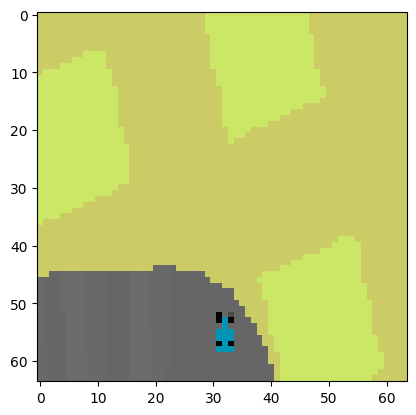

In [16]:
plt.imshow(a[1][3])

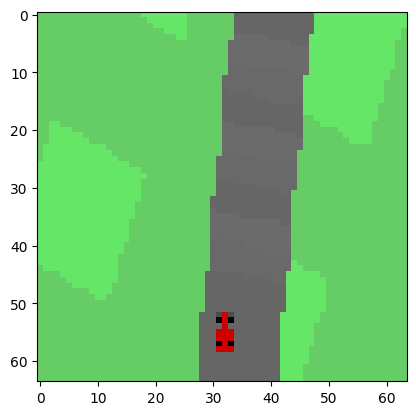

In [17]:
plt.imshow(a[0][3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


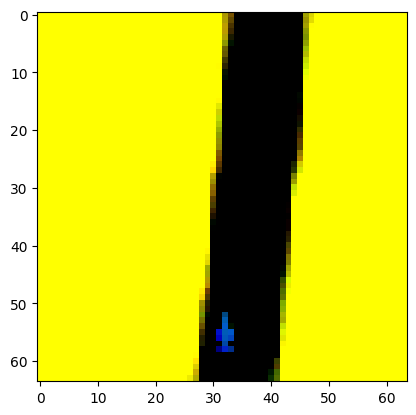

In [23]:
plt.imshow(model.decode(mu[3:4], classcode2[3:4])[0])

In [ ]:
tf.reduce_sum(model.decode(mu2[3:4], classcode2[3:4])[0] - model.decode(mu[3:4], classcode2[3:4])[0])

In [ ]:
mu_r = tf.random.normal(shape=[1, 16])
plt.imshow(model.decode(mu_r, classcode[3:4])[0])

In [ ]:
mu2[3]